In [30]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, Attention
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K
import random
import torch
import os
import re
import json
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Input
from keras.models import Model
from keras.layers import *

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
file_path = '/content/drive/My Drive/SE Project/Reddit Dataset/train-balanced-sarcasm.csv'
sarcasm_data = pd.read_csv(file_path)
sarcasm_data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [33]:
sarcasm_data.drop(['author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'], axis=1, inplace=True)
sarcasm_data.dropna(inplace=True)
sarcasm_data.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [34]:
sarcasm_data['label'].value_counts()

label
0    505403
1    505368
Name: count, dtype: int64

In [35]:
mispell_dict = {"ain't": "is not", "cannot": "can not", "aren't": "are not", "can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "wont": "will not", "won't've": "will not have", "would've": "would have",
                "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
                'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

mispell_dict = {k.lower(): v.lower() for k, v in mispell_dict.items()}

In [36]:
def preprocessing_text(s):
    s = str(s).lower().strip()
    s = " ".join([mispell_dict[word] if word in mispell_dict.keys() else word for word in s.split()])

    s = re.sub('\n', '', s)
    s = re.sub(r"([?!,+=—&%\'\";:¿।।।|\(\){}\[\]//])", r" \1 ", s)
    s = re.sub('[ ]{2,}', ' ', s).strip()
    return s

In [37]:
sarcasm_data['comment'] = sarcasm_data['comment'].apply(preprocessing_text)
sarcasm_data.head()

,label,comment
0,0,nc and nh.
1,0,you do know west teams play against west teams...
2,0,"they were underdogs earlier today , but since ..."
3,0,"this meme is not funny none of the "" new york ..."
4,0,i could use one of those tools.


In [38]:
TOTAL_WORDS = 40000
MAX_LEN = 50
EMBEDDING_SIZE = 300

In [39]:
# Reconstruct the tokenizer object
tokenizer = Tokenizer(num_words=TOTAL_WORDS)
tokenizer.fit_on_texts(list(sarcasm_data['comment']))

train_data = tokenizer.texts_to_sequences(sarcasm_data['comment'])
train_data = pad_sequences(train_data, maxlen = MAX_LEN)
target = sarcasm_data['label']

In [ ]:
EMBEDDING_FILE = '/content/drive/My Drive/SE Project/crawl-300d-2M.vec'

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(EMBEDDING_FILE)))

word_index = tokenizer.word_index
nb_words = min(TOTAL_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_SIZE))

In [ ]:
for word, i in tqdm(word_index.items()):
    if i >= TOTAL_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [42]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    tf.random.set_seed(seed)

seed_everything(2020)

In [43]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.dot(x, self.W), axis=-1)
        at = tf.keras.backend.exp(et)
        at_sum = tf.keras.backend.sum(at, axis=1, keepdims=True)
        at = at / at_sum
        at = tf.keras.backend.expand_dms(at, axis=-1)
        output = x * at
        return tf.keras.backend.sum(output, axis=1)

In [44]:
input_layer = Input(shape=(MAX_LEN,))

embedding_layer = Embedding(TOTAL_WORDS, EMBEDDING_SIZE, weights = [embedding_matrix])(input_layer)

LSTM_layer = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
attention = TimeDistributed(Dense(1))(LSTM_layer)

#By running softmax on axis 1 we force attention_values
# to sum up to 1. We are effectively assigning a "weight" to each timestep
# Output shape is still (None,1) but each value changes
attention_vals = Softmax(axis=1)(attention)

# Multiply the encoded timestep by the respective weight
# I.e. we are scaling each timestep based on its weight
# Output shape is (None,5): (None,5)*(None,1)=(None,5)
scaled_vecs = Multiply()([LSTM_layer,attention_vals])

# Sum up all scaled timesteps into 1 vector
# i.e. obtain a weighted sum of timesteps
# Output shape is (5,) : Observe the time dimension got collapsed
context_vector = Lambda(lambda x: K.sum(x,axis=1))(scaled_vecs)

dense_layer_1 = Dense(64, activation="relu")(context_vector)
dropout_1 = Dropout(0.5)(dense_layer_1)

dense_layer_2 = Dense(32, activation="relu")(dropout_1)
dropout_2 = Dropout(0.5)(dense_layer_2)

output_layer = Dense(1, activation="sigmoid")(dropout_2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 50, 300)              1200000   ['input_2[0][0]']             
                                                          0                                       
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 50, 256)              439296    ['embedding_1[0][0]']         
 onal)                                                                                            
                                                                                            

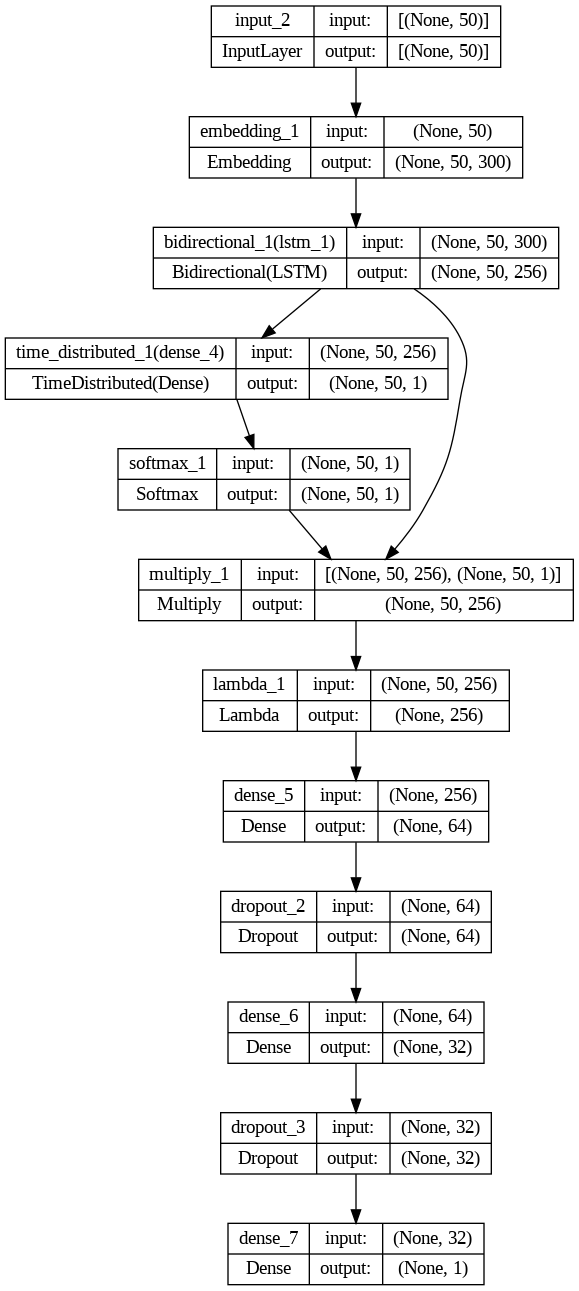

In [45]:
plot_model(model, show_shapes=True)

In [46]:
BATCH_SIZE = 512
EPOCHS = 30

history = model.fit(
    train_data, target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

Epoch 1/30
1580/1580 [==============================] - 91s 55ms/step - loss: 0.5707 - accuracy: 0.7064 - val_loss: 0.5298 - val_accuracy: 0.7332
Epoch 2/30
1580/1580 [==============================] - 67s 42ms/step - loss: 0.5255 - accuracy: 0.7412 - val_loss: 0.5226 - val_accuracy: 0.7358
Epoch 3/30
1580/1580 [==============================] - 65s 41ms/step - loss: 0.4931 - accuracy: 0.7623 - val_loss: 0.5240 - val_accuracy: 0.7379
Epoch 4/30
1580/1580 [==============================] - 65s 41ms/step - loss: 0.4540 - accuracy: 0.7857 - val_loss: 0.5588 - val_accuracy: 0.7337
Epoch 5/30
1580/1580 [==============================] - 65s 41ms/step - loss: 0.4108 - accuracy: 0.8093 - val_loss: 0.6083 - val_accuracy: 0.7288
Epoch 6/30
1580/1580 [==============================] - 65s 41ms/step - loss: 0.3671 - accuracy: 0.8315 - val_loss: 0.7447 - val_accuracy: 0.7216
Epoch 7/30
1580/1580 [==============================] - 64s 40ms/step - loss: 0.3278 - accuracy: 0.8507 - val_loss: 0.8142 -

In [73]:
model.save('/content/drive/My Drive/SE Project/sarcasm_detection.keras')

In [ ]:
model.save()

In [48]:
with open("tokenizer_word_index.json", "w") as json_file:
    json.dump(tokenizer.word_index, json_file, indent=4)

In [49]:
model_with_attention_output = Model(input_layer, [output_layer, context_vector])

In [50]:
model_with_attention_output.save('sarcasm_detection_att.h5')

In [51]:
def get_attention_weights(model , model_with_attention_output, sentence):
    # Tokenize the input sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    # Pad sequences to match model input shape
    sequence = pad_sequences(sequence, maxlen=MAX_LEN)
    # Predict with the model to get attention weights
    _, attention_weights = model_with_attention_output.predict(sequence)
    print(_[0][0])
    # Reshape attention weights to remove extra dimensions
    attention_weights = attention_weights.squeeze()
    return attention_weights

In [68]:
sample_sentence = "Oh, what a delightful surprise, another meeting to discuss the agenda for the meeting about scheduling the next meeting. Because clearly, our time is best spent rehashing the same topics ad nauseam instead of, oh I don't know, actually getting something done. It's not like we have anything better to do with our lives, like watch paint dry or count the blades of grass in the parking lot. Keep up the stellar work, team. We're definitely on track to achieve mediocrity."

# Get the attention weights for the sample sentence
attention_weights = get_attention_weights(model , model_with_attention_output, sample_sentence)

# Print attention weights for each word in the sentence
words = sample_sentence.split()
for word, weight in zip(words, attention_weights):
    print(f"Word: {word}, Attention Weight: {weight}")

1/1 [==============================] - 0s 30ms/step
0.8787432
Word: Oh,, Attention Weight: -0.12696877121925354
Word: what, Attention Weight: -0.4473937153816223
Word: a, Attention Weight: -0.14316865801811218
Word: delightful, Attention Weight: -0.011378823779523373
Word: surprise,, Attention Weight: 0.23306526243686676
Word: another, Attention Weight: -0.004866208881139755
Word: meeting, Attention Weight: 0.12116017937660217
Word: to, Attention Weight: 0.06814762949943542
Word: discuss, Attention Weight: 0.06680386513471603
Word: the, Attention Weight: 0.2123538851737976
Word: agenda, Attention Weight: -0.02288752608001232
Word: for, Attention Weight: -0.06093699857592583
Word: the, Attention Weight: 0.19563215970993042
Word: meeting, Attention Weight: -0.017931941896677017
Word: about, Attention Weight: 0.07785681635141373
Word: scheduling, Attention Weight: -0.1034330353140831
Word: the, Attention Weight: -0.09462588280439377
Word: next, Attention Weight: 0.1598171889781952
Word: m

# Prediction

In [19]:
sentence = "you are so funny"

sentence = preprocessing_text(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen = MAX_LEN)
prediction = model.predict(sentence)
# print(prediction)
prediction[0][0]

1/1 [==============================] - 1s 797ms/step


0.74745697

# Highlightings

In [ ]:
# print(train_data.shape)
# new_data = train_data[0:100,:]
# new_target = target[0:100]
# print(new_data.shape)
# print(new_target.shape)

(1010771, 50)
(100, 50)
(100,)


In [ ]:
import json

# Load the saved feature importance values
# with open("gradient_importance.json", "r") as json_file:
#     gradient_importance = json.load(json_file)

with open("permutation_importance.json", "r") as json_file:
    permutation_importance = json.load(json_file)

with open("lofo_importance.json", "r") as json_file:
    lofo_importance = json.load(json_file)

# Define a function to calculate feature importance for a sentence
def calculate_sentence_importance(sentence, tokenizer, importance_values):
    tokenized_sentence = tokenizer.texts_to_sequences([sentence])
    for sublist in tokenized_sentence:
      print(sublist)
      for index in sublist:
        # print(index)
        if index in importance_values:
          print(index)

    word_indices = [index for sublist in tokenized_sentence for index in sublist if index in importance_values]
    importance_scores = [importance_values[index] for index in word_indices]
    importance_dict = dict(zip(word_indices, importance_scores))
    return importance_dict


# Example sentence for testing
sentence_to_test = "you are so funny"

# Preprocess the sentence
preprocessed_sentence = preprocessing_text(sentence_to_test)

# Calculate and print feature importance for the sentence using Permutation Feature Importance
permutation_sentence_importance = calculate_sentence_importance(preprocessed_sentence, tokenizer, permutation_importance)
print("Permutation Sentence Importance:", permutation_sentence_importance)

# Calculate and print feature importance for the sentence using LOFO
lofo_sentence_importance = calculate_sentence_importance(preprocessed_sentence, tokenizer, lofo_importance)
print("LOFO Sentence Importance:", lofo_sentence_importance)


[6, 13, 23, 318]
Permutation Sentence Importance: {}
[6, 13, 23, 318]
LOFO Sentence Importance: {}
